# Chat Analyzer (Basic)

This notebook helps you analyze chat logs (e.g., WhatsApp-like exports) to see message counts, activity over time, top words, and optional sentiment.

What you'll do here:
- Install and import dependencies
- Load chat text (paste or file path)
- Parse messages into a clean table
- Run basic analytics and charts
- (Optional) Sentiment analysis

Supported input (initially): WhatsApp-like formats such as:
- "[12/03/2023, 9:14 pm] John Doe: Hey there!"
- "12/03/2023, 21:14 - John Doe: Hey there!"

You can extend the parser for other formats later.


In [15]:
# Setup: installs (safe to re-run). On some systems, restart the kernel after install.
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split('==')[0].split('[')[0])
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'])

# Core
deps = [
    'pandas',
    'matplotlib',
    'seaborn',
    'regex',  # better re
]
for d in deps:
    pip_install(d)

# Optional
optional_deps = [
    'wordcloud',
    'textblob',
]
for d in optional_deps:
    try:
        __import__(d)
    except Exception:
        try:
            pip_install(d)
        except Exception:
            print(f"Optional dependency '{d}' not installed; features using it will be skipped.")


In [16]:
# Imports and global settings
import re
import regex as re2  # if you prefer advanced regex; kept optional usage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except Exception:
    TEXTBLOB_AVAILABLE = False

sns.set(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

print({'wordcloud': WORDCLOUD_AVAILABLE, 'textblob': TEXTBLOB_AVAILABLE})


{'wordcloud': True, 'textblob': True}


## Provide your chat data

Paste your chat export text below or set a file path to a `.txt` chat export. For now, we support WhatsApp-like formats; multi-line messages are handled.


In [17]:
from pathlib import Path
file_path = r"chat.txt"

path = Path(file_path)
if path.exists():
    raw_text = path.read_text(encoding='utf-8', errors='ignore')
    print(f"Loaded {file_path} with {len(raw_text.splitlines())} lines")
else:
    print(f"File '{file_path}' not found. Falling back to sample text.")
    raw_text = sample_chat

print(raw_text.splitlines()[:5])


Loaded chat.txt with 8366 lines
['10/26/24, 11:25\u202fPM - Messages and calls are end-to-end encrypted. Only people in this chat can read, listen to, or share them. Learn more.', '10/26/24, 11:25\u202fPM - This chat has added privacy for your phone number. Tap to learn more.', '7/29/24, 5:12\u202fPM - Ankur Sir created community "BTech Five 2022-26"', '7/29/24, 5:12\u202fPM - You were added', '10/26/24, 11:11\u202fPM - Akshay Sir: https://careers.mastercard.com/us/en/job/R-228651/Data-Scientist-Intern-Summer-2025-India']


## Parse chat into a table

This parser handles common WhatsApp formats and multi-line messages. It extracts `timestamp`, `author`, and `message`.


In [18]:
import datetime as dt

# Normalize helper for unicode spaces and BOM
_DEF_SPACE_CHARS = {'\u202f': ' ', '\u00a0': ' '}  # narrow no-break space, nbsp

def _normalize_line(line: str) -> str:
    if not isinstance(line, str):
        return ''
    for k, v in _DEF_SPACE_CHARS.items():
        line = line.replace(k, v)
    return line.strip('\ufeff')

# Generic patterns capturing [date, time] or date, time - then the rest
# Example 1: [12/03/2023, 9:14 pm] John: Hi
pattern_bracket_header = re.compile(
    r"^\[(?P<date>\d{1,2}/\d{1,2}/\d{2,4}),\s*(?P<time>\d{1,2}:\d{2}(?::\d{2})?\s*(?:[ap]m)?)\]\s*(?P<rest>.+)$",
    re.IGNORECASE,
)
# Example 2: 12/03/2023, 21:14 - John: Hi  OR  12/03/2023, 9:14 pm - John: Hi
pattern_dash_header = re.compile(
    r"^(?P<date>\d{1,2}/\d{1,2}/\d{2,4}),\s*(?P<time>\d{1,2}:\d{2}(?::\d{2})?\s*(?:[ap]m)?)\s*[-\u2013]\s*(?P<rest>.+)$",
    re.IGNORECASE,
)


def parse_lines(text: str):
    lines = text.splitlines()
    messages = []
    current = None
    unmatched = 0

    for raw in lines:
        line = _normalize_line(raw.rstrip('\n'))
        m = pattern_bracket_header.match(line) or pattern_dash_header.match(line)
        if m:
            if current:
                messages.append(current)
            date = m.group('date')
            time = m.group('time')
            rest = m.group('rest')
            # Split rest into author and message by first ': '
            if ': ' in rest:
                author, msg = rest.split(': ', 1)
            else:
                # System message without explicit author
                author, msg = 'System', rest
            current = {
                'date': date,
                'time': time,
                'author': author.strip(),
                'message': msg,
                'raw': line,
            }
        else:
            # Continuation line
            if current is not None:
                current['message'] += "\n" + line
            else:
                unmatched += 1
                continue

    if current:
        messages.append(current)

    if unmatched:
        print(f"Note: {unmatched} lines did not match a timestamp and were skipped or attached.")

    return messages


def to_dataframe(messages):
    rows = []
    for item in messages:
        date = (item.get('date') or '').strip()
        time = (item.get('time') or '00:00').strip()
        author = (item.get('author') or '').strip()
        msg = (item.get('message') or '').strip()

        dt_val = None
        # Try multiple specific formats first
        for fmt in [
            "%d/%m/%Y, %I:%M %p",
            "%d/%m/%Y, %I:%M:%S %p",
            "%d/%m/%Y, %H:%M",
            "%d/%m/%Y, %H:%M:%S",
            "%d/%m/%y, %I:%M %p",
            "%d/%m/%y, %H:%M",
        ]:
            try:
                dt_val = dt.datetime.strptime(f"{date}, {time}", fmt)
                break
            except Exception:
                continue
        if dt_val is None:
            # Fallback to pandas parser with dayfirst
            dt_val = pd.to_datetime(f"{date} {time}", dayfirst=True, errors='coerce')

        rows.append({
            'timestamp': dt_val,
            'author': author or 'Unknown',
            'message': msg,
        })

    df = pd.DataFrame(rows)
    df = df.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    return df

messages = parse_lines(raw_text)
df = to_dataframe(messages)
df.head()


,timestamp,author,message
0,2024-01-12 12:21:00,Akshay Sir,Check out this job at Intrics India: https://w...
1,2024-01-12 12:22:00,Akshay Sir,Check out this job at AdrushAI: https://www.li...
2,2024-01-12 12:24:00,Akshay Sir,Check out this job at Sherlock Studio: https:/...
3,2024-01-12 13:14:00,Devesh Sir,"(section-E and D)In DBMS Lab file, students co..."
4,2024-01-12 21:19:00,Devesh Sir,https://m.facebook.com/story.php?story_fbid=pf...


## Analytics and visuals

Run the cells below to see participant activity, timelines, top words, and optional sentiment.


Messages per author:
 author
Aviral Sir          879
Ankur Sir           710
Akshay Sir          364
+91 97611 15480     351
Devesh Sir          195
+91 76400 88914     193
+91 63978 71885      65
Anubhav Sir          55
Prince Sir Kumar     38
System               31
Sk Sir               30
Ansh Sir             25
+91 99104 40018      15
+91 82798 26483      12
+91 78190 25664      11
+91 75001 80717      11
+91 94583 19912       6
Rahul Sir             5
+91 94140 02624       4
+91 89797 84117       4
+91 80774 38744       2
Naman                 1
+91 82669 03777       1
+91 82184 83243       1
Name: count, dtype: int64


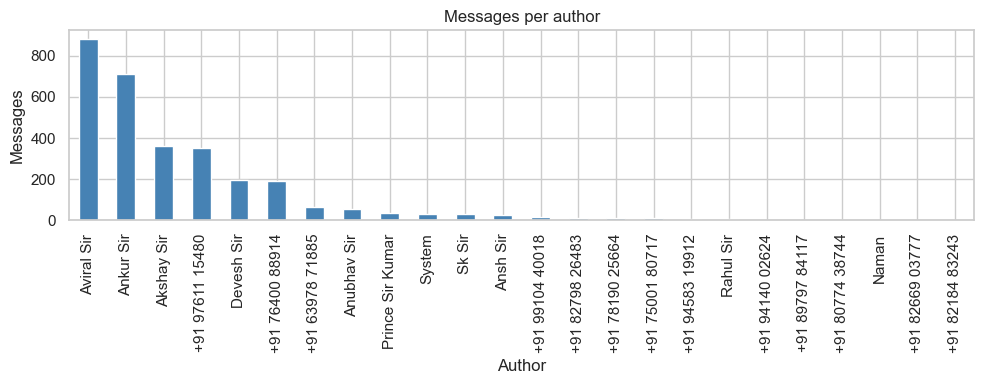

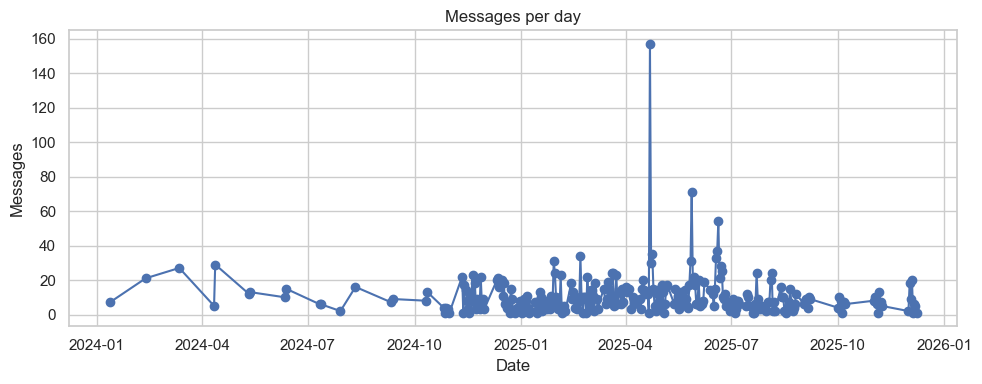

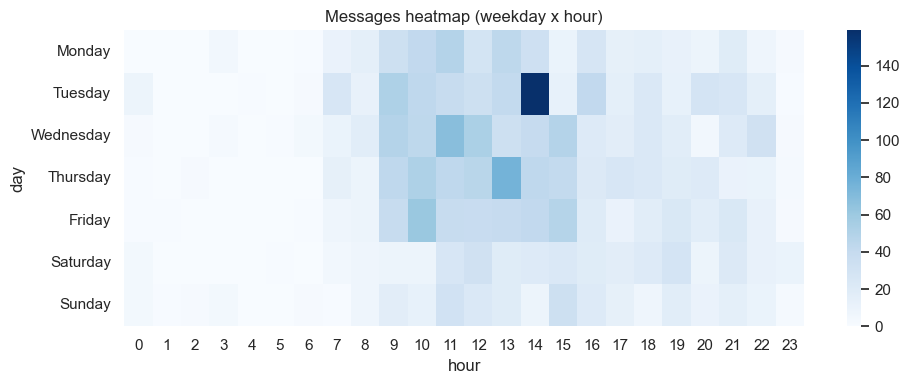

Top words: [('media', 923), ('omitted', 919), ('students', 665), ('will', 508), ('section', 230), ('message', 229), ('singh', 216), ('form', 203), ('lab', 165), ('kindly', 153), ('today', 144), ('dear', 141), ('joshi', 140), ('any', 132), ('deleted', 122), ('bisht', 122), ('fill', 122), ('time', 120), ('come', 115), ('call', 115)]


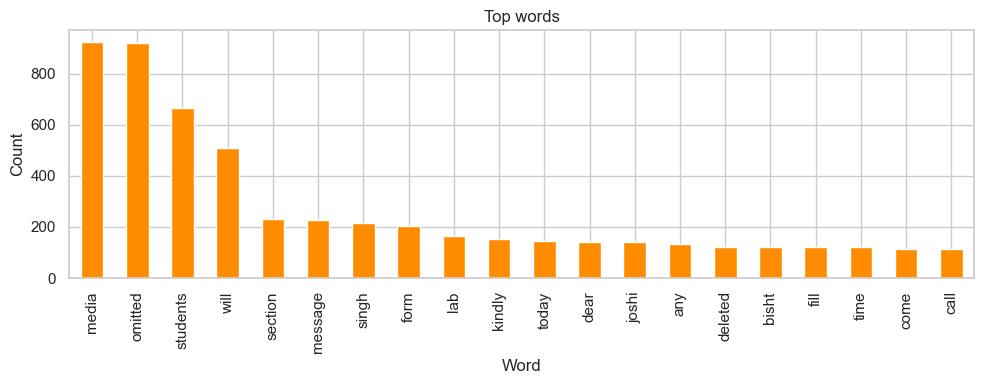

In [19]:
# Basic analytics
assert not df.empty, "Parsed DataFrame is empty. Check input format or file path."

# Time features
_df = df.copy()
_df['date'] = pd.to_datetime(_df['timestamp']).dt.date
_df['day'] = pd.to_datetime(_df['timestamp']).dt.day_name()
_df['hour'] = pd.to_datetime(_df['timestamp']).dt.hour

# Messages per author
counts_by_author = _df['author'].value_counts()
print("Messages per author:\n", counts_by_author)
ax = counts_by_author.plot(kind='bar', color='steelblue', title='Messages per author')
ax.set_xlabel('Author'); ax.set_ylabel('Messages')
plt.tight_layout(); plt.show()

# Messages per day (timeline)
msg_per_day = _df.groupby('date').size()
ax = msg_per_day.plot(kind='line', marker='o', title='Messages per day')
ax.set_xlabel('Date'); ax.set_ylabel('Messages')
plt.tight_layout(); plt.show()

# Hourly heatmap by weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
_df['day'] = pd.Categorical(_df['day'], categories=weekday_order, ordered=True)
heat = _df.pivot_table(index='day', columns='hour', values='message', aggfunc='count', fill_value=0, observed=False)
sns.heatmap(heat, cmap='Blues')
plt.title('Messages heatmap (weekday x hour)')
plt.tight_layout(); plt.show()

# Top words (simple)
import re as _re
from collections import Counter

text = "\n".join(_df['message'].astype(str).tolist()).lower()
text = _re.sub(r"http\S+", " ", text)
text = _re.sub(r"[@#]\w+", " ", text)
text = _re.sub(r"[^a-z\s]", " ", text)
words = [w for w in text.split() if len(w) > 2]
stopwords = set(['the','and','for','you','that','with','this','have','are','was','but','not','your','from','they','get','just','like','what','when','can','all','one','out','his','her','she','him','our','who','why','how','been','were','there','their','them','had','did','does','got','let','hey','yeah','okay','ok','lol'])
words = [w for w in words if w not in stopwords]
common = Counter(words).most_common(20)
print("Top words:", common)

labels = [w for w,_ in common]
vals = [c for _,c in common]
if labels:
    ax = pd.Series(vals, index=labels).plot(kind='bar', color='darkorange', title='Top words')
    ax.set_xlabel('Word'); ax.set_ylabel('Count')
    plt.tight_layout(); plt.show()
else:
    print('No words after filtering.')


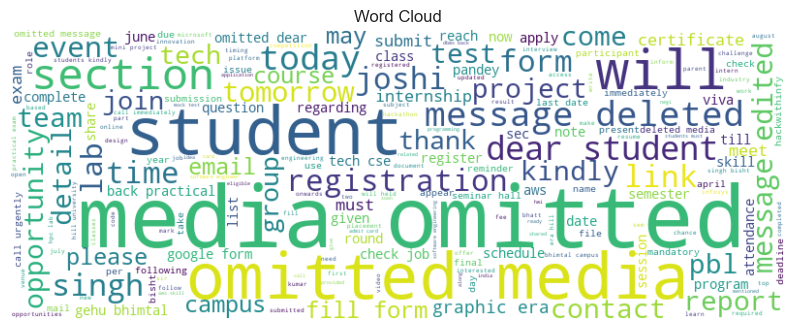

In [20]:
# Word cloud (optional)
if WORDCLOUD_AVAILABLE:
    wc_text = " ".join(words) if 'words' in globals() else ""
    if wc_text.strip():
        wc = WordCloud(width=800, height=300, background_color='white').generate(wc_text)
        plt.figure(figsize=(10,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud')
        plt.show()
    else:
        print('No words available for word cloud.')
else:
    print('wordcloud is not installed; skipping word cloud.')


            timestamp      author  sentiment
0 2024-01-12 12:21:00  Akshay Sir        0.0
1 2024-01-12 12:22:00  Akshay Sir        0.0
2 2024-01-12 12:24:00  Akshay Sir        0.0
3 2024-01-12 13:14:00  Devesh Sir        0.1
4 2024-01-12 21:19:00  Devesh Sir        0.0

Avg sentiment by author:
 author
+91 82669 03777     0.600000
Naman               0.383333
+91 89797 84117     0.225000
Ansh Sir            0.139190
Prince Sir Kumar    0.101844
+91 82798 26483     0.084896
Anubhav Sir         0.080342
+91 80774 38744     0.068182
Sk Sir              0.056944
+91 99104 40018     0.056313
Akshay Sir          0.050885
+91 75001 80717     0.046494
Ankur Sir           0.044712
Devesh Sir          0.032549
+91 97611 15480     0.026825
Rahul Sir           0.023750
Aviral Sir          0.023748
System              0.022177
+91 63978 71885     0.017325
+91 82184 83243     0.000000
+91 94583 19912     0.000000
+91 76400 88914    -0.001035
+91 78190 25664    -0.011364
+91 94140 02624    -0.031250


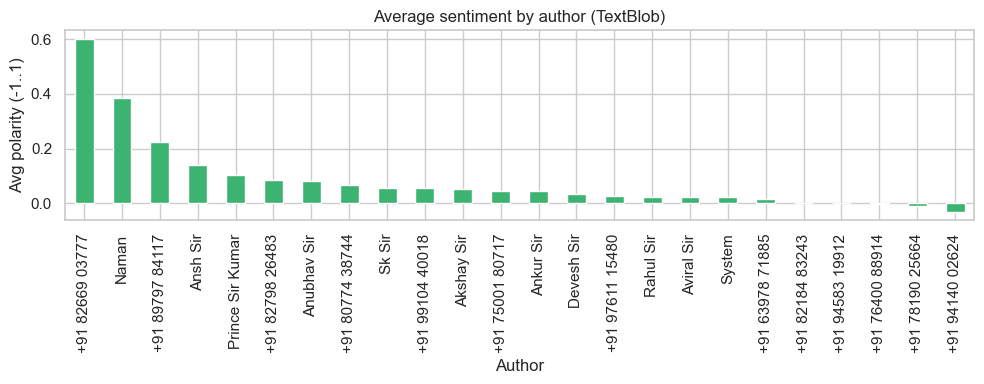

In [21]:
# Optional: sentiment analysis per message
if TEXTBLOB_AVAILABLE:
    df['sentiment'] = df['message'].astype(str).apply(lambda t: TextBlob(t).sentiment.polarity)
    print(df[['timestamp','author','sentiment']].head())

    # Average sentiment by author
    sent_by_author = df.groupby('author')['sentiment'].mean().sort_values(ascending=False)
    print("\nAvg sentiment by author:\n", sent_by_author)
    ax = sent_by_author.plot(kind='bar', color='mediumseagreen', title='Average sentiment by author (TextBlob)')
    ax.set_xlabel('Author'); ax.set_ylabel('Avg polarity (-1..1)')
    plt.tight_layout(); plt.show()
else:
    print('textblob is not installed; skipping sentiment.')


## How to run

1) Place your chat export file as `chat.txt` in the same folder as this notebook.
2) Run all cells top-to-bottom: Kernel → Restart & Run All.
3) If the file is not found, the notebook will use the built-in sample text.
4) Outputs:
   - Table preview of parsed messages
   - Messages per author, timeline per day, weekday x hour heatmap
   - Top words bar chart
   - Optional word cloud and sentiment by author

Troubleshooting:
- If dates use a different locale/format, parsing may fail. Share a few sample lines to adapt the regex.
- For large exports, rendering charts may take a bit longer.
- If `wordcloud`/`textblob` didn’t install, they’ll be skipped automatically.
